In [1]:
#Imports

#Google Search Lib
#from google_images_download import google_images_download

#Keras layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense

#Keras extras
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical

#SciKit Encoders
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

#Libs Extras
import matplotlib.pyplot as plt
from random import shuffle
from pathlib import Path
from PIL import Image
import numpy as np
import warnings
import json
import h5py
import os

warnings.filterwarnings("ignore")

### Baixando as imagens necessárias para treino e teste da rede neural

- Rodar apenas uma vez para baixar as imagens, filtrar manualmente as imagens sem contexto.

In [2]:
# response = google_images_download.googleimagesdownload()


# def getImages(key):
#     arguments = {"keywords": key,
#                  "chromedriver":"./chromedriver",
#                  "limit":200,
#                  "offset":100,
#                  "print_urls":True,
#                  "output_directory":"dataset/validation/"}
#     print(arguments)
#     response.download(arguments)

# pokemonList = ["Bulbasaur","Charmander","Squirtle","Caterpie","Metapod","Butterfree","Weedle","Kakuna","Beedrill","Pidgey","Rattata","Raticate","Spearow","Fearow","Ekans","Pikachu","Sandshrew","Nidoqueen","Nidoking","Clefairy","Vulpix","Ninetales","Jigglypuff","Zubat","Oddish","Gloom","Paras","Venonat","Venomoth","Dugtrio","Meowth","Persian","Psyduck","Golduck","Mankey","Growlithe","Poliwag","Abra","Machop","Bellsprout","Tentacool","Geodude","Ponyta","Slowpoke","Magnemite","Farfetch'd","Doduo","Seel","Grimer","Shellder","Cloyster","Gastly","Onix","Drowzee","Hypno","Krabby","Voltorb","Exeggcute","Exeggutor","Cubone","Hitmonlee","Hitmonchan","Lickitung","Koffing","Rhyhorn","Chansey","Tangela","Kangaskhan","Horsea","Goldeen","Seaking","Staryu","Starmie","Mr. Mime","Scyther","Jynx","Electabuzz","Magmar","Pinsir","Tauros","Magikarp","Gyarados","Lapras","Ditto","Eevee","Vaporeon","Jolteon","Flareon","Porygon","Omanyte","Kabuto","Kabutops","Aerodactyl","Snorlax","Articuno","Zapdos","Moltres","Dratini","Dragonite","Mewtwo"]

# for pokemon in pokemonList:
#     getImages(pokemon)

### Montando caminhos da base

In [3]:
root = Path(".")
datasetPaths = list(root.rglob("dataset2//train/**/*"))


### Convertendo os PNG para JPG

- Usar as duas celulas abaixo apenas se necessário converter as imagens com transparência

In [4]:
for path in datasetPaths:
    if "DS_Store" not in path.stem and path.is_file():
        try:
            im = Image.open(path)
            if im.format == "PNG":
                rgb_im = im.convert('RGB')
                rgb_im.save(str(path.parent) + "\\" + str(path.stem) + ".jpg")
                os.remove(path)
            else:
                continue
        except:
            os.remove(path)

### Estatisticas  dos tamanhos das imagens

In [5]:
def get_size_statistics(paths, typePath):
    heights = []
    widths = []
    img_count = 0
    for path in paths:
        if "DS_Store" not in path.stem and path.is_file():
            data = np.array(Image.open(path))
            heights.append(data.shape[0])
            widths.append(data.shape[1])
            img_count += 1
    avg_height = sum(heights) / len(heights)
    avg_width = sum(widths) / len(widths)

    print("Number of " + typePath + " images: " + str(img_count))
    print("Average Height of "+ typePath + "images: " + str(avg_height)+" px")
    print("Max Height of "+ typePath + "images: " + str(max(heights))+" px")
    print("Min Height of "+ typePath + "images: " + str(min(heights))+" px")
    print("Average Width of "+ typePath + "images: " + str(avg_width)+" px")
    print("Max Width of "+ typePath + "images: " + str(max(widths))+" px")
    print("Min Width of "+ typePath + "images: " + str(min(widths))+" px")
    print("\n")

In [6]:
get_size_statistics(datasetPaths, "Dataset")

Number of Dataset images: 10662
Average Height of Datasetimages: 628.2451697617707 px
Max Height of Datasetimages: 5000 px
Min Height of Datasetimages: 94 px
Average Width of Datasetimages: 721.5148189833052 px
Max Width of Datasetimages: 8000 px
Min Width of Datasetimages: 80 px




### OneHotEncoding das classes

In [7]:
nomes = []
for path in datasetPaths:
    if path.is_dir():
        nomes.append(path.name)
    else:
        continue

In [8]:
len(nomes)

149

- Salvando JSON com os nomes e índices dos pokemons, para usar no retorno da predição posteriormente

In [9]:
dictNomes = dict(zip(range(len(nomes)), nomes))

with open('pokemonList.json', 'w') as pl:
    json.dump(dictNomes, pl)

- Encoding

In [10]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(nomes)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
labels = onehot_encoder.fit_transform(integer_encoded)

### Carregando as imagens das bases de treino e validação, aplicando os seguintes processos:
- Convertendo para escala de cinza, assim a rede vai identificar as formas e então as cores serão irrelevantes.
- Transformando todas as imagens para o mesmo tamanho.
- Transformando as imagens em uma lista, onde o primeiro elemento é a imagem em formato de np.array e o segundo é a label da imagem de acordo com a classe.
- Randomizando a lista para evitar bias na rede

In [11]:
IMG_SIZE_Y = 96 #em pixeis
IMG_SIZE_X = 96 

def load_data(paths, labels, nomes):
    data = []
    for path in paths:
        if "DS_Store" not in path.stem and path.is_file():
            img = Image.open(path)
            img = img.convert('L')
            img = img.resize((IMG_SIZE_X, IMG_SIZE_Y), Image.ANTIALIAS)
            data.append([np.array(img), labels[nomes.index(path.parent.name)]])
            
    shuffle(data)
    return data

In [12]:
dataset = load_data(datasetPaths, labels, nomes)

### Preparando a base para treino
- Separando em x_train (matrix de imagens) e y_train (vetor de classes).

In [13]:
datasetImages = np.array([i[0] for i in dataset]).reshape(-1, IMG_SIZE_X, IMG_SIZE_Y, 1)
datasetLabels = np.array([i[1] for i in dataset])

In [14]:
datasetImages.shape

(10662, 96, 96, 1)

In [15]:
datasetLabels.shape

(10662, 149)

In [16]:
# Scaling data in array
datasetImages = datasetImages / 255.0

# Convert labels to categorical format
# datasetLabels = to_categorical(range(len(nomes)), len(nomes))

# Splitting data to train and test datasets
# I'll use these datasets only for training, for final predictions I'll use random pictures from internet
X_train, X_test, y_train, y_test = train_test_split(datasetImages, datasetLabels, test_size = 0.2, stratify = datasetLabels, shuffle = True, random_state = 666)

### Preparando a rede e as camadas

In [23]:
model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3), padding = 'same', activation = 'relu', input_shape =(IMG_SIZE_X, IMG_SIZE_Y, 1), kernel_initializer = 'he_normal'))
model.add(BatchNormalization(axis = -1))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size = (3, 3), padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization(axis = -1))
model.add(Conv2D(64, kernel_size = (3, 3), padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization(axis = -1))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size = (3, 3), padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization(axis = -1))
model.add(Conv2D(128, kernel_size = (3, 3), padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization(axis = -1))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, kernel_size = (3, 3), padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization(axis = -1))
model.add(Conv2D(256, kernel_size = (3, 3), padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization(axis = -1))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(len(nomes), activation = 'softmax'))

In [24]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [25]:
#Treinando o modelo
model.fit(X_train, y_train, batch_size = 32, epochs = 50, verbose = 1, use_multiprocessing=True)

Train on 8529 samples
Epoch 1/50
8529/8529 [==============================] - 11s 1ms/sample - loss: 0.0447 - accuracy: 0.9932
Epoch 2/50
8529/8529 [==============================] - 7s 835us/sample - loss: 0.0417 - accuracy: 0.9932
Epoch 3/50
8529/8529 [==============================] - 7s 834us/sample - loss: 0.0398 - accuracy: 0.9933
Epoch 4/50
8529/8529 [==============================] - 7s 834us/sample - loss: 0.0383 - accuracy: 0.9933
Epoch 5/50
8529/8529 [==============================] - 7s 836us/sample - loss: 0.0367 - accuracy: 0.9933
Epoch 6/50
8529/8529 [==============================] - 7s 837us/sample - loss: 0.0355 - accuracy: 0.9933
Epoch 7/50
8529/8529 [==============================] - 7s 848us/sample - loss: 0.0341 - accuracy: 0.9934
Epoch 8/50
8529/8529 [==============================] - 7s 854us/sample - loss: 0.0328 - accuracy: 0.9935
Epoch 9/50
8529/8529 [==============================] - 7s 850us/sample - loss: 0.0315 - accuracy: 0.9935
Epoch 10/50
8529/8529 [==

### Verificando a perda e a precisão do modelo a cada epoch.

Text(0.5, 1.0, 'loss')

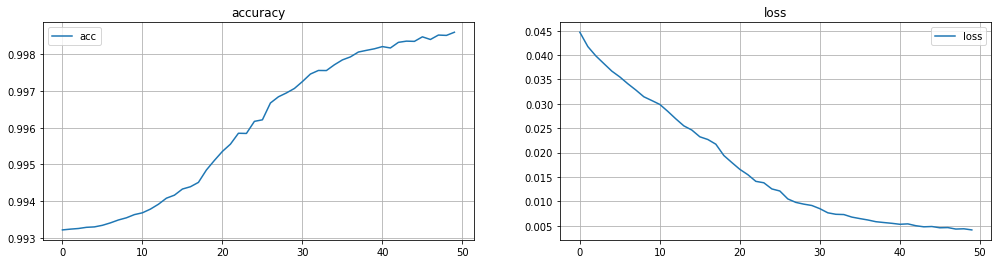

In [26]:
fig = plt.figure(figsize = (17, 4))
    
plt.subplot(121)
plt.plot(model.history.history['accuracy'], label = 'acc')
#plt.plot(model.history.history['val_accuracy'], label = 'val_acc')
plt.legend()
plt.grid()
plt.title(f'accuracy')

plt.subplot(122)
plt.plot(model.history.history['loss'], label = 'loss')
#plt.plot(model.history.history['val_loss'], label = 'val_loss')
plt.legend()
plt.grid()
plt.title(f'loss')

### Aplicando base de validação no modelo.

In [27]:
loss, acc = model.evaluate(X_test, y_test, verbose = 1)

2133/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [28]:
loss

0.0342657443588321

In [29]:
acc

0.9935816

### Testando com outra imagem fora da base

In [30]:
from tensorflow import cast
from tensorflow import float32

In [31]:
predict = Image.open("dataset2/train/Abra/0282b2f3a22745f1a436054ea15a0ae5.jpg")
predict = predict.convert('L')
predict = predict.resize((IMG_SIZE_X, IMG_SIZE_Y), Image.ANTIALIAS)

In [32]:
image = cast(np.array(predict).reshape(-1, IMG_SIZE_X, IMG_SIZE_Y, 1), float32)

In [33]:
model.predict_classes(image)

array([105], dtype=int64)

- Salvando modelo

In [34]:
model.save("secondeModel.h5")